2021320020 복헌준


In [ ]:
! pip install torch==2.0.0 torchvision==0.15.1

In [ ]:
!pip install d2l==1.0.3

## 7.1. From Fully Connected Layers to Convolutions

## 7.2. Convolutions for Images

In [53]:
import torch
from torch import nn
from d2l import torch as d2l

In [54]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [55]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [56]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [57]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [58]:
K = torch.tensor([[1.0, -1.0]])

In [59]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [60]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [61]:
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2
for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 3.119
epoch 4, loss 0.811
epoch 6, loss 0.254
epoch 8, loss 0.091
epoch 10, loss 0.035


In [62]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9739, -1.0117]])

## 7.3. Padding and Stride

In [63]:
import torch
from torch import nn

In [64]:
def comp_conv2d(conv2d, X):

    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)

    return Y.reshape(Y.shape[2:])

conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [65]:
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [66]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [67]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 7.4. Multiple Input and Multiple Output Channels

In [68]:
import torch
from d2l import torch as d2l

In [69]:
def corr2d_multi_in(X, K):

    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [70]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [71]:
def corr2d_multi_in_out(X, K):

    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [72]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [73]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [74]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))

    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [75]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 7.5. Pooling

In [76]:
import torch
from torch import nn
from d2l import torch as d2l

In [77]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [78]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [79]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

In [80]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [81]:
pool2d = nn.MaxPool2d(3)

pool2d(X)

tensor([[[[10.]]]])

In [82]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [83]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [84]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [85]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 7.6. Convolutional Neural Networks (LeNet)

In [86]:
import torch
from torch import nn
from d2l import torch as d2l

In [87]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [88]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


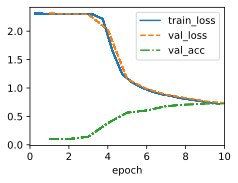

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## 8.2. Networks Using Blocks (VGG)

In [37]:
import torch
from torch import nn
from d2l import torch as d2l

In [38]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [39]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [40]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [41]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

KeyboardInterrupt: 

## 8.6. Residual Networks (ResNet) and ResNeXt

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [3]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 3, 6, 6])

In [4]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [5]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [7]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [8]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


KeyboardInterrupt: 

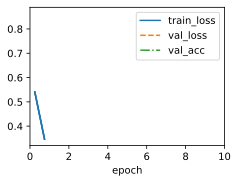

In [42]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## Discussions/Exercises

7.1. From Fully Connected Layers to Convolutions

exercise
Q : What happens with convolutions when an object is at the boundary of an image?

A : When objects are at the boundary of an image, padding techniques like zero padding, reflective padding, or replicate padding are commonly used to ensure that the convolutional kernel can still be applied effectively. These techniques help the network to handle edge cases and reduce the loss of information at the boundaries.

disscussion



The price paid for this drastic reduction in parameters is that our features are now translation invariant and that our layer can only incorporate local information, when determining the value of each hidden activation. All learning depends on imposing inductive bias.

7.2. Convolutions for Images

exercise

Construct an image X with diagonal edges.

What happens if you apply the kernel K in this section to it?

What happens if you transpose X?

What happens if you transpose K?



In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

In [11]:
X = np.array([
    [0, 0, 0, 0, 0],
    [0, 255, 0, 0, 0],
    [0, 0, 255, 0, 0],
    [0, 0, 0, 255, 0],
    [0, 0, 0, 0, 255]
])

In [15]:
K = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

In [16]:
X_convolved = ndimage.convolve(X, K, mode='constant', cval=0.0)

In [13]:
X_transposed = X.T

In [17]:
X_transposed_convolved = ndimage.convolve(X_transposed, K, mode='constant', cval=0.0)

In [18]:
K_transposed = K.T

In [19]:
X_convolved_with_transposed_kernel = ndimage.convolve(X, K_transposed, mode='constant', cval=0.0)

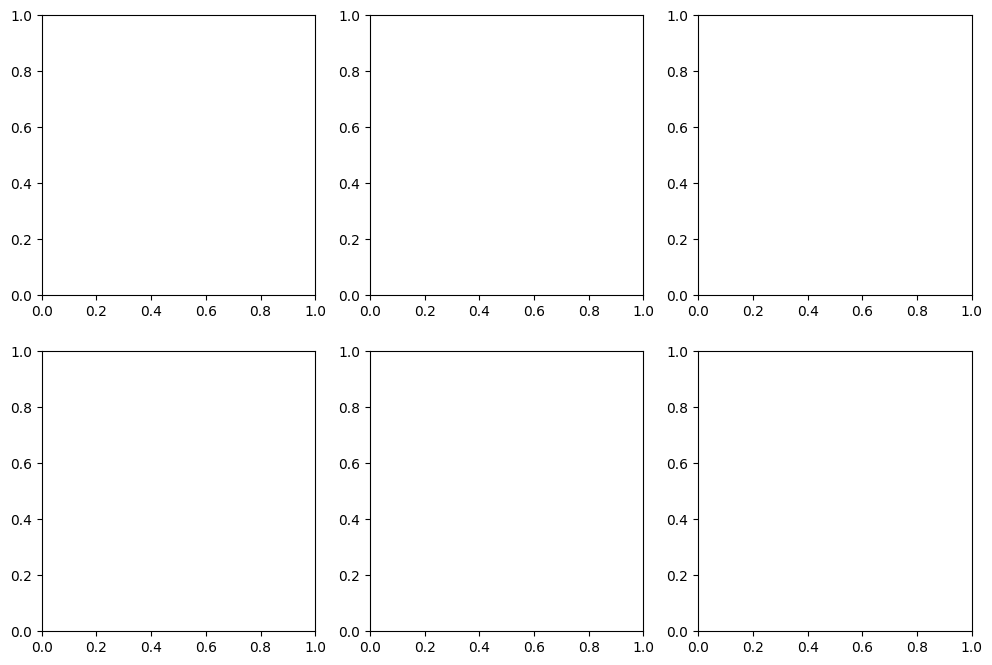

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

In [21]:
axes[0, 0].imshow(X, cmap='gray')
axes[0, 0].set_title("Original Image X")
axes[0, 0].axis('off')

(-0.5, 4.5, 4.5, -0.5)

In [22]:
axes[0, 1].imshow(X_convolved, cmap='gray')
axes[0, 1].set_title("X Convolved with K")
axes[0, 1].axis('off')

(-0.5, 4.5, 4.5, -0.5)

In [23]:
axes[0, 2].imshow(X_transposed, cmap='gray')
axes[0, 2].set_title("Transposed Image X")
axes[0, 2].axis('off')

(-0.5, 4.5, 4.5, -0.5)

In [24]:
axes[1, 0].imshow(X_transposed_convolved, cmap='gray')
axes[1, 0].set_title("Transposed X Convolved with K")
axes[1, 0].axis('off')

(-0.5, 4.5, 4.5, -0.5)

In [25]:
axes[1, 1].imshow(X_convolved_with_transposed_kernel, cmap='gray')
axes[1, 1].set_title("X Convolved with Transposed K")
axes[1, 1].axis('off')

(-0.5, 4.5, 4.5, -0.5)

In [26]:
axes[1, 2].imshow(K_transposed, cmap='gray')
axes[1, 2].set_title("Transposed Kernel K")
axes[1, 2].axis('off')

(-0.5, 2.5, 2.5, -0.5)

In [27]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

discussion

Cross-Correlation


To illustrate this, suppose that a convolutional layer performs cross-correlation and learns the kernel in Fig. 7.2.1, which is here denoted as the matrix
𝐾. Assuming that other conditions remain unchanged, when this layer instead performs strict convolution, the learned kernel
𝐾′will be the same as 𝐾 after
𝐾
′
is flipped both horizontally and vertically. That is to say, when the convolutional layer performs strict convolution for the input in Fig. 7.2.1 and
𝐾
′
, the same output (cross-correlation of the input and
𝐾
) will be obtained.

7.3. Padding and Stride

exercise


Q : For audio signals, what does a stride of 2 correspond to?

A :
In audio signal processing, a stride of 2 is equivalent to halving the sampling rate, resulting in a downsampled version of the original signal.

discussion

CNNs commonly use convolution kernels with odd height and width values, such as 1, 3, 5, or 7. Choosing odd kernel sizes has the benefit that we can preserve the dimensionality while padding with the same number of rows on top and bottom, and the same number of columns on left and right.

7.4. Multiple Input and Multiple Output Channels

exercise

Q : Assume that we have two convolution kernels of size
 and
, respectively (with no nonlinearity in between).

Prove that the result of the operation can be expressed by a single convolution.

What is the dimensionality of the equivalent single convolution?

Is the converse true, i.e., can you always decompose a convolution into two smaller ones?


A1 :

I' = I * K1


O = I' * K2


O = I * K

O = ( I * K1 ) * K2 = I * ( K1 * K2)


This shows that the convolution of the input with
K1 followed by the convolution with
K2 is equivalent to a single convolution of the input with the kernel K = K1 * K2

A2 : k = k1 + k2 -1

A3 : it is not always possible to decompose a single convolution into two smaller convolutions in a general sense. The reason is that the process of decomposition would require finding specific kernels
K1 and
K2 such that their convolution equals the original kernel
K. For many arbitrary kernels, there may not exist such a factorization into smaller kernels due to the lack of a unique solution or the inability to split the kernel into appropriate components.

discussion


1 * 1  Convolutional Layer

Because the minimum window is used, the 1 * 1
 convolution loses the ability of larger convolutional layers to recognize patterns consisting of interactions among adjacent elements in the height and width dimensions. The only computation of the 1 * 1
 convolution occurs on the channel dimension.


7.5. Pooling

exercise




implement average pooling through a convolution.

In [28]:
import numpy as np
import scipy.ndimage as ndimage

In [29]:
input_matrix = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
])

In [30]:
kernel = np.array([
    [0.25, 0.25],
    [0.25, 0.25]
])

In [31]:
output = ndimage.convolve(input_matrix, kernel, mode='constant', cval=0.0)

In [32]:
pooled_output = output[::2, ::2]

In [33]:
print("Original Input:")
print(input_matrix)
print("\nConvolved Output (before downsampling):")
print(output)
print("\nPooled Output (after downsampling):")
print(pooled_output)

Original Input:
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

Convolved Output (before downsampling):
[[ 3  4  5  3]
 [ 7  8  9  5]
 [11 12 13  7]
 [ 6  7  7  4]]

Pooled Output (after downsampling):
[[ 3  5]
 [11 13]]


discussion


Padding and Stride

As with convolutional layers, pooling layers change the output shape. And as before, we can adjust the operation to achieve a desired output shape by padding the input and adjusting the stride. We can demonstrate the use of padding and strides in pooling layers via the built-in two-dimensional max-pooling layer from the deep learning framework. We first construct an input tensor X whose shape has four dimensions, where the number of examples (batch size) and number of channels are both 1.

7.6. Convolutional Neural Networks (LeNet)

exercise

Let’s modernize LeNet. Implement and test the following changes:

Replace average pooling with max-pooling.

Replace the softmax layer with ReLU.

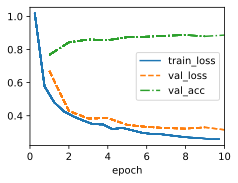

In [34]:
import torch
from torch import nn
from d2l import torch as d2l

def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class ModernLeNet(d2l.Classifier):
    """The modernized LeNet-5 model."""

    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Changed to Max-Pooling
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Changed to Max-Pooling
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)  # Removed the softmax layer
        )

@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

# Instantiate the modernized LeNet model and display layer summary
model = ModernLeNet()
model.layer_summary((1, 1, 28, 28))

# Training the ModernLeNet model
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = ModernLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)


8.2. Networks Using Blocks (VGG)

exercise

Q : Compared with AlexNet, VGG is much slower in terms of computation, and it also needs more GPU memory.

Compare the number of parameters needed for AlexNet and VGG.

Compare the number of floating point operations used in the convolutional layers and in the fully connected layers.


A : VGG-16 requires significantly more computational resources than AlexNet. It has about 138 million parameters compared to AlexNet's 61 million, primarily due to its deeper architecture and more convolutional layers. In terms of floating point operations (FLOPs), VGG-16 performs around 15.6 billion FLOPs, which is much higher than AlexNet's 1.18 billion FLOPs. Most of the computational cost in VGG-16 comes from its convolutional layers, whereas AlexNet's cost is more evenly distributed between convolutional and fully connected layers. This makes VGG-16 more demanding in both computation and GPU memory compared to AlexNet.

discussion

Progress in this field mirrors that of VLSI (very large scale integration) in chip design where engineers moved from placing transistors to logical elements to logic blocks (Mead, 1980). Similarly, the design of neural network architectures has grown progressively more abstract, with researchers moving from thinking in terms of individual neurons to whole layers, and now to blocks, repeating patterns of layers. A decade later, this has now progressed to researchers using entire trained models to repurpose them for different, albeit related, tasks. Such large pretrained models are typically called foundation models (Bommasani et al., 2021).

8.6. Residual Networks (ResNet) and ResNeXt




exercise


What are the major differences between the Inception block in Fig. 8.4.1 and the residual block? How do they compare in terms of computation, accuracy, and the classes of functions they can describe?


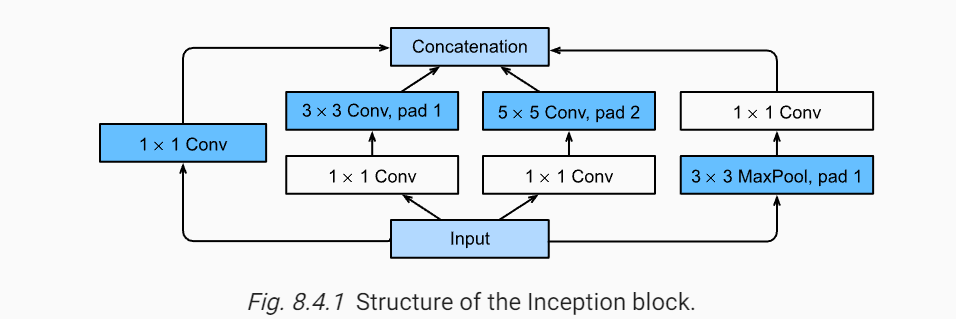


A : Inception blocks are well-suited for capturing multi-scale features, making them highly flexible but relatively computationally expensive due to their parallel operations.
Residual blocks enable stable training in deep networks, making them more efficient in terms of computation and maintaining high performance even in very deep architectures.